# Summary
This demonstrates reconstruction of a Fresnel CDI dataset and compares the result to ePIE reconstruction. 

The probe structure allows reconstruction in CDI mode, i.e. without real-space overlap constraints. 

Scanning CDI reconstruction is also possible here, but results in a lower-quality image because of scan position jitter in this dataset.

## Object ePIE reconstruction: 
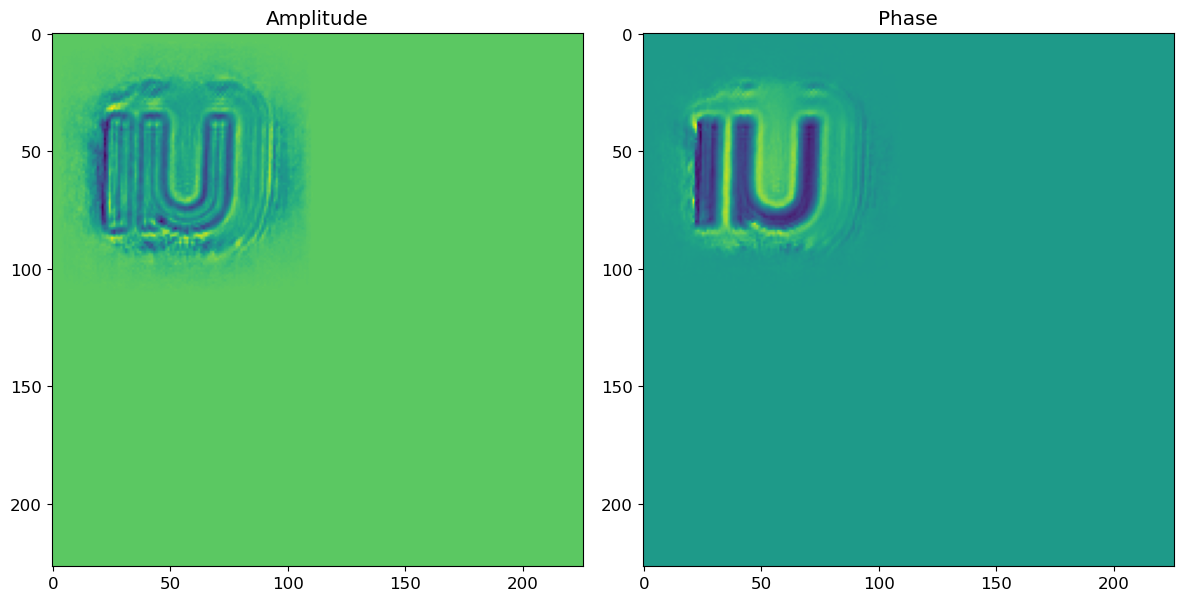

In [1]:
from scipy.ndimage import zoom
import numpy as np

def init():
    from ptycho import params as p
    
    p.cfg['nepochs'] = 50
    p.cfg['output_prefix'] = 'tmp'
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['positions.provided'] = True
    p.cfg['probe.big'] = True
    p.cfg['probe.mask'] = False

    p.cfg['data_source'] = 'generic'
    p.cfg['gridsize'] = 2
    p.cfg['probe_scale'] = 5
    p.cfg['train_data_file_path'] = 'train_data.npz'
    p.cfg['test_data_file_path'] = 'test_data.npz'


# IMPORTANT: must call init() BEFORE the dataset definition
init()

In [2]:
!ln -s ../tests/test_generic_loader.py
import test_generic_loader;
train_raw, test_raw = test_generic_loader.test_generic_loader(False);

ln: failed to create symbolic link './test_generic_loader.py': File exists


2024-06-04 21:50:27.298729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 21:50:27.298759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 21:50:27.299921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 21:50:27.305428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 21:50:27.804398: W tensorflow/compiler/tf2

DEBUG: Setting probe_mask to tf.Tensor(
[[[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]


 [[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]


 [[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]


 ...


 [[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]


 [[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]


 [[[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]

  ...

  [[0.+0.j]]

  [[0.+0.j]]

  [[0.+0.j]]]], shape=(64, 64, 1, 1), dtype=complex64) in params
diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,

In [3]:
from ptycho import probe
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

DEBUG: Setting probe to tf.Tensor(
[[[-0.00651507+1.4380710e-02j]
  [ 0.01283696+1.7046710e-02j]
  [-0.03114917+4.6514906e-03j]
  ...
  [-0.00702214-2.3603119e-02j]
  [ 0.01094224+4.2910941e-02j]
  [-0.03161414-1.0882590e-02j]]

 [[ 0.01503608+8.6904122e-03j]
  [ 0.00689386-2.6355132e-02j]
  [-0.00529759+2.6545117e-02j]
  ...
  [-0.00754843-4.3737483e-03j]
  [ 0.01948243-1.0916220e-02j]
  [ 0.01479488-6.1852732e-03j]]

 [[ 0.00480844-1.8001227e-02j]
  [-0.02428803+8.5864980e-03j]
  [-0.00135581+2.1527281e-02j]
  ...
  [ 0.00340497+2.7510835e-02j]
  [ 0.00907174-4.9521357e-02j]
  [ 0.02616441+2.3693807e-02j]]

 ...

 [[ 0.0269782 +6.2509187e-02j]
  [-0.02179178+1.1454654e-03j]
  [-0.0062075 -1.4121581e-02j]
  ...
  [ 0.02911633+4.3498869e-03j]
  [-0.02921897+1.1685294e-02j]
  [ 0.0171632 -4.5767725e-02j]]

 [[-0.04212391-3.5519141e-05j]
  [ 0.01608743-5.1518381e-03j]
  [-0.02547074+4.0439606e-02j]
  ...
  [-0.02248588-3.0875669e-03j]
  [ 0.00716038-2.3343405e-02j]
  [ 0.03915279-1.95125

In [4]:
from ptycho import xpp

In [5]:
tf.random.set_seed(45)
np.random.seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
ptycho_dataset.test_data.X.shape, ptycho_dataset.train_data.X.shape

DEBUG: Setting timestamp to 06/04/2024, 21:50:29 in params
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (512, 64, 64, 4)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1087, 64, 64, 4)


2024-06-04 21:50:30.078932: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


INFO: None
<PtychoDataContainer X=(512, 64, 64, 4) Y_I=(512, 64, 64, 4) Y_phi=(512, 64, 64, 4) norm_Y_I=() coords_nominal=(512, 1, 2, 4) coords_true=(512, 1, 2, 4) nn_indices=(512, 4) mean=255.950 global_offsets=(512, 1, 2, 1) mean=63.003 local_offsets=(512, 1, 2, 4) mean=-0.000 probe=(64, 64, 1)>
INFO: None
<PtychoDataContainer X=(1087, 64, 64, 4) Y_I=(1087, 64, 64, 4) Y_phi=(1087, 64, 64, 4) norm_Y_I=() coords_nominal=(1087, 1, 2, 4) coords_true=(1087, 1, 2, 4) nn_indices=(1087, 4) mean=540.800 global_offsets=(1087, 1, 2, 1) mean=57.246 local_offsets=(1087, 1, 2, 4) mean=-0.000 probe=(64, 64, 1)>
INFO: train data:
<PtychoDataContainer X=(512, 64, 64, 4) Y_I=(512, 64, 64, 4) Y_phi=(512, 64, 64, 4) norm_Y_I=() coords_nominal=(512, 1, 2, 4) coords_true=(512, 1, 2, 4) nn_indices=(512, 4) mean=255.950 global_offsets=(512, 1, 2, 1) mean=63.003 local_offsets=(512, 1, 2, 4) mean=-0.000 probe=(64, 64, 1)>
INFO: test data:
<PtychoDataContainer X=(1087, 64, 64, 4) Y_I=(1087, 64, 64, 4) Y_phi=(1

2024-06-04 21:50:32.257813: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-04 21:50:32.257831: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-06-04 21:50:32.257855: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-06-04 21:50:32.258085: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-06-04 21:50:32.258093: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-06-04 21:50:32.258097: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-06-04 21:50:32.258101: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

DEBUG: Setting intensity_scale to 1474.246 in params
DEBUG: Setting probe to tf.Tensor(
[[[[-0.00319568+7.0538078e-03j]]

  [[ 0.00629659+8.3614942e-03j]]

  [[-0.01527882+2.2815787e-03j]]

  ...

  [[-0.00344439-1.1577444e-02j]]

  [[ 0.00536722+2.1048024e-02j]]

  [[-0.01550689-5.3379633e-03j]]]


 [[[ 0.00737527+4.2626895e-03j]]

  [[ 0.00338147-1.2927320e-02j]]

  [[-0.0025985 +1.3020508e-02j]]

  ...

  [[-0.00370254-2.1453449e-03j]]

  [[ 0.00955623-5.3544589e-03j]]

  [[ 0.00725696-3.0339065e-03j]]]


 [[[ 0.00235856-8.8296887e-03j]]

  [[-0.0119134 +4.2117187e-03j]]

  [[-0.00066503+1.0559236e-02j]]

  ...

  [[ 0.00167016+1.3494198e-02j]]

  [[ 0.00444973-2.4290465e-02j]]

  [[ 0.01283377+1.1621927e-02j]]]


 ...


 [[[ 0.01323294+3.0661060e-02j]]

  [[-0.01068897+5.6185632e-04j]]

  [[-0.00304481-6.9267037e-03j]]

  ...

  [[ 0.0142817 +2.1336407e-03j]]

  [[-0.01433205+5.7316935e-03j]]

  [[ 0.00841863-2.2449290e-02j]]]


 [[[-0.02066198-1.7422311e-05j]]

  [[ 0.00789096-2.5

2024-06-04 21:50:34.860683: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-04 21:50:34.861205: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x60fbb9d3eb90
2024-06-04 21:50:34.950087: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-04 21:50:36.242493: I external/local_xla/xla/service/service.cc:168] XLA service 0x79cc40194bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-04 21:50:36.242524: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-04 21:50:36.245958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717552236.312303  886798 device_compiler.h:186] Compiled cluster 

31/31 [==============================] - 10s 88ms/step - loss: 8941628416.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 293.6862 - distribution_lambda_loss: 8941628416.0000 - val_loss: 1469136640.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 145.2725 - val_distribution_lambda_loss: 1469136640.0000 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 1446638848.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 146.8777 - distribution_lambda_loss: 1446638848.0000 - val_loss: 1243685760.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 134.1550 - val_distribution_lambda_loss: 1243685760.0000 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 1223571712.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 135.5782 - distribution_lambda_loss: 1223571712.0000 - val_loss: 1096074112.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 

(TensorShape([1087, 64, 64, 4]), TensorShape([512, 64, 64, 4]))

# Dataset description

In [6]:
print(test_raw)

RawData: 
xcoords: (1087,) 
ycoords: (1087,) 
xcoords_start: (1087,) 
ycoords_start: (1087,) 
diff3d: (1087, 64, 64) 
probeGuess: (64, 64) 
scan_index: (1087,) 
objectGuess: Present


In [7]:
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data

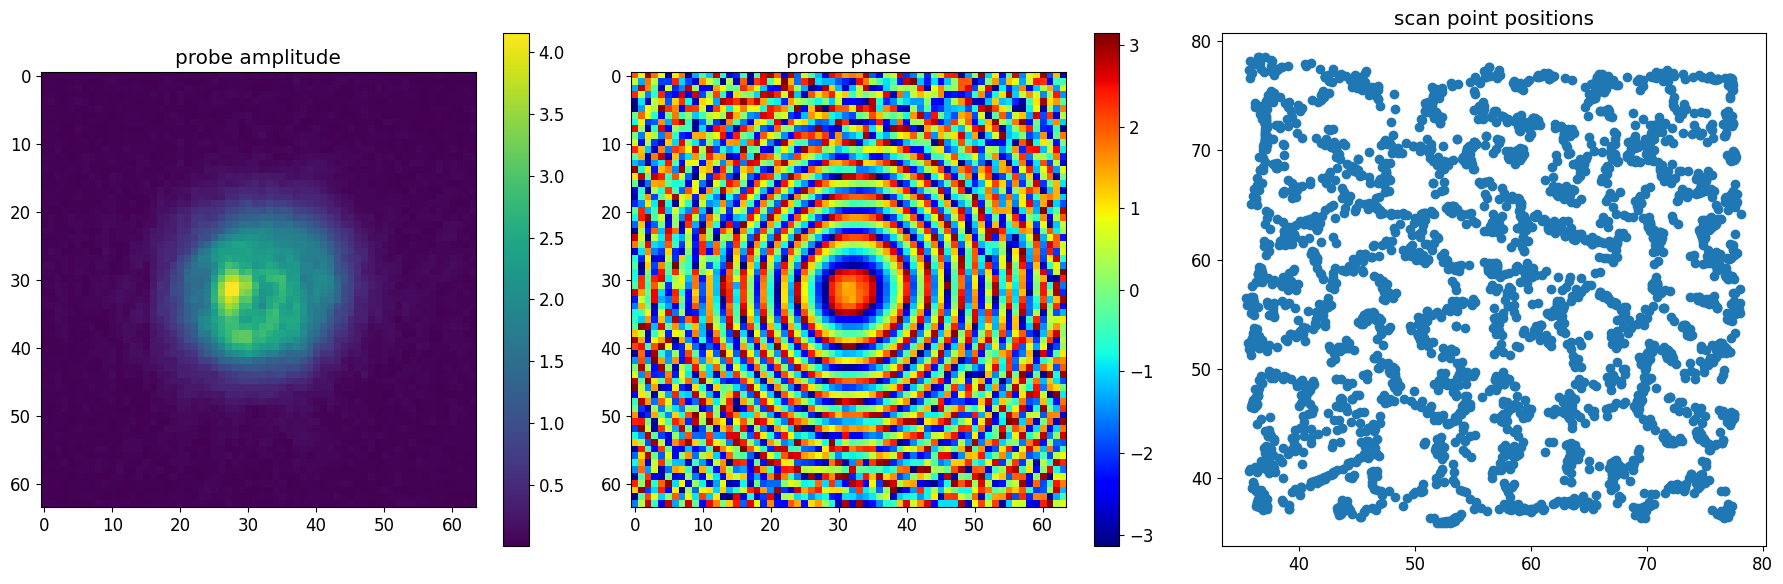

In [8]:
# Note the randomized scan point positions
probeshow(probeGuess, ptycho_dataset.test_data)

## Reconstruct the full test object image and compare to the ePIE reconstruction:

102/102 [==============================] - 1s 6ms/step
PADDING SIZE: 22
PADDING SIZE: 22


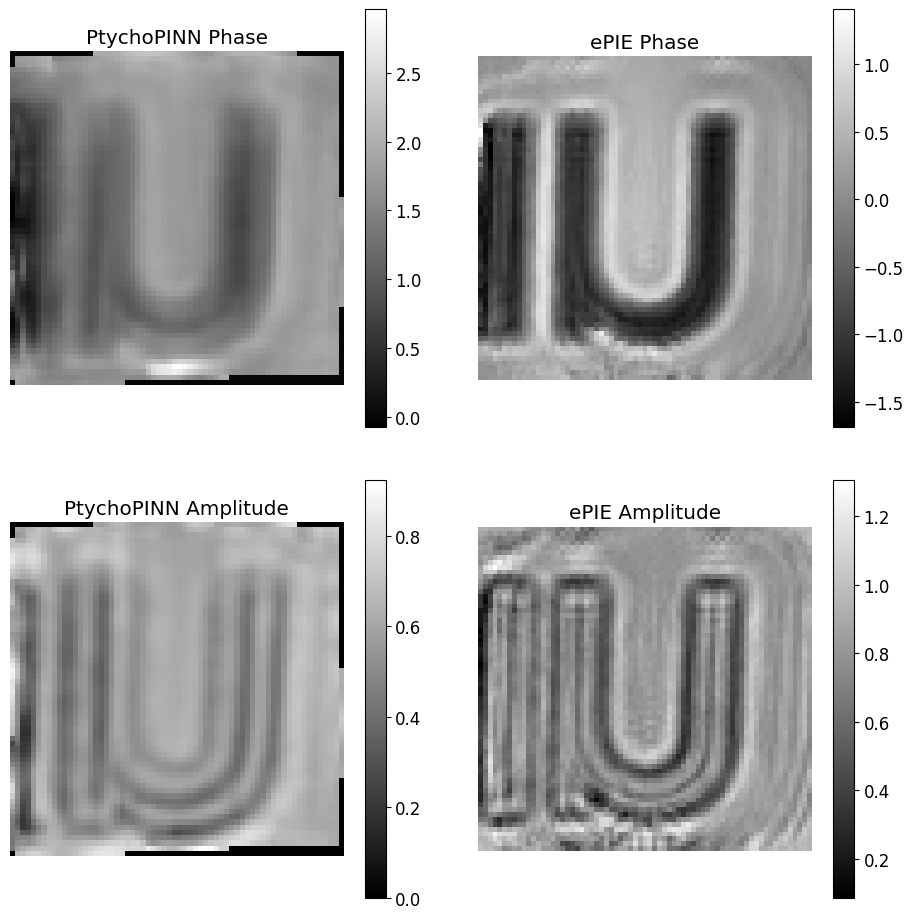

CPU times: user 1.28 s, sys: 588 ms, total: 1.87 s
Wall time: 1.68 s


In [9]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

Reconstruction for a single solution region:

phase min: -3.141592 phase max: 3.141569


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/evaluation.py:80: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


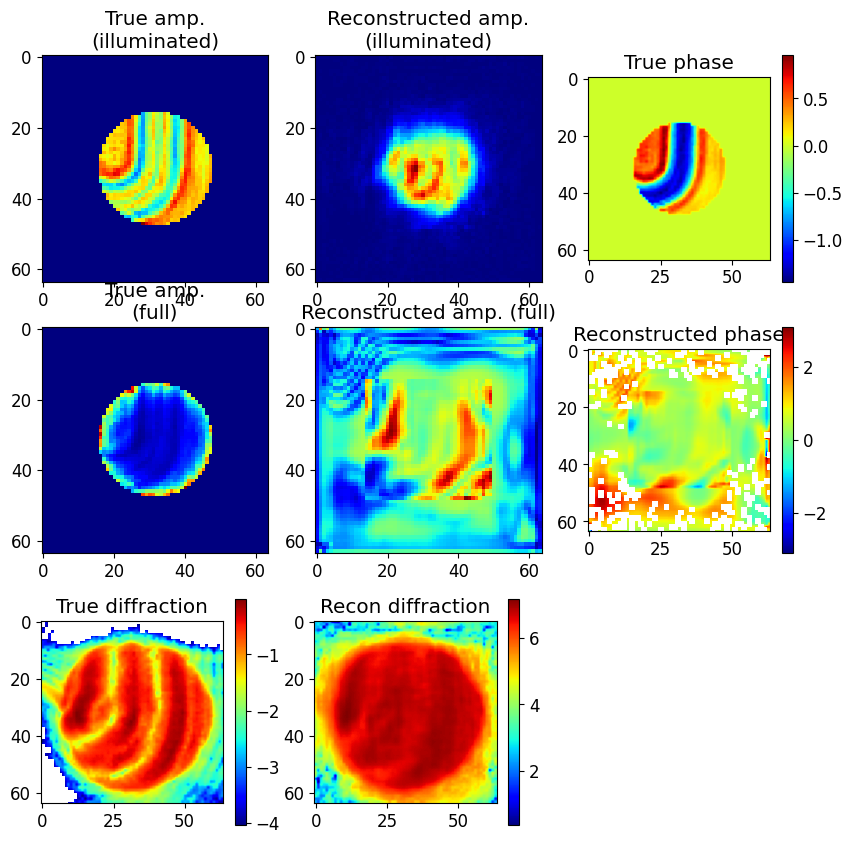

In [11]:
i = 200
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0, 0]), 0,
                    crop = False);

In [ ]:
# TODO: is the loss different here from on the main branch?